In [66]:
import pandas as pd

games_season2022=pd.read_csv('games_regular.csv')

## 패작인지?

In [67]:
import pandas as pd
import numpy as np

# ===== 설정 =====
DET_KEYWORD = 'detroit'  # 팀명 매칭(대소문자 무시)
BLOWOUT = 20             # 대패 기준: -20점 이하
MIN_GAMES = 5            # 하위팀 상대 최소 표본수
MIN_DIFF = 0.20          # 하위 vs 베이스 대패률 차이가 20%p 이상이면 의심
MULTIPLIER = 2.0         # 하위 대패률이 베이스의 2배 이상이면 의심
MIN_RATE = 0.50          # 하위 대패률 자체가 50% 이상이면 의심

# ===== 0) 준비 =====
df = games_season2022.copy()
need = ['HOME_TEAM','VISITOR_TEAM','HOME_TEAM_LVL','VISITOR_TEAM_LVL','PTS_home','PTS_away']
miss = [c for c in need if c not in df.columns]
if miss:
    raise KeyError(f"필수 컬럼 누락: {miss}")

# 디트로이트가 나온 경기만
det = df[df['HOME_TEAM'].astype(str).str.contains(DET_KEYWORD, case=False, na=False) |
         df['VISITOR_TEAM'].astype(str).str.contains(DET_KEYWORD, case=False, na=False)].copy()
if det.empty:
    raise ValueError("디트로이트 경기 없음")

# 숫자화
det['PTS_home'] = pd.to_numeric(det['PTS_home'], errors='coerce')
det['PTS_away'] = pd.to_numeric(det['PTS_away'], errors='coerce')
det = det.dropna(subset=['PTS_home','PTS_away','HOME_TEAM_LVL','VISITOR_TEAM_LVL'])

# ===== 1) 상대(opp) 등급 만들기 (홈/원정 모두 정확히) =====
lvl_map = {'상위팀':'top','중위팀':'mid','하위팀':'low',
           'top':'top','mid':'mid','middle':'mid','low':'low','bottom':'low'}
is_home = det['HOME_TEAM'].astype(str).str.contains(DET_KEYWORD, case=False, na=False)
opp_lvl = np.where(
    is_home,
    det['VISITOR_TEAM_LVL'].astype(str).str.strip().str.lower().map(lambda x: lvl_map.get(x, x)),
    det['HOME_TEAM_LVL'].astype(str).str.strip().str.lower().map(lambda x: lvl_map.get(x, x))
)
opp_lvl = pd.Series(opp_lvl, index=det.index)

# ===== 2) 디트로이트 관점 마진/대패 여부 =====
det_pts = np.where(is_home, det['PTS_home'], det['PTS_away'])
opp_pts = np.where(is_home, det['PTS_away'], det['PTS_home'])
margin = pd.Series(det_pts - opp_pts, index=det.index)
bl = margin <= -BLOWOUT  # 20+ 대패 여부

# ===== 3) 하위팀 vs 그 외 비율 비교 (단일 규칙 판정) =====
low_mask = opp_lvl.eq('low')
n_low  = int(low_mask.sum())
k_low  = int((bl & low_mask).sum())
rate_low  = k_low / n_low if n_low > 0 else np.nan

base_mask = ~low_mask
n_base = int(base_mask.sum())
k_base = int((bl & base_mask).sum())
rate_base = k_base / n_base if n_base > 0 else np.nan

suspicious = False
reason = ""
if n_low >= MIN_GAMES and np.isfinite(rate_low) and np.isfinite(rate_base) and n_base > 0:
    if (rate_low - rate_base) >= MIN_DIFF:
        suspicious, reason = True, f"하위팀 상대 대패률이 베이스 대비 {(rate_low-rate_base)*100:.1f}%p 높음(≥{MIN_DIFF*100:.0f}%p)."
    if (rate_low >= MIN_RATE) and (rate_low >= rate_base * MULTIPLIER):
        suspicious = True
        reason = (reason + f" 하위팀 {rate_low*100:.1f}% vs 베이스 {rate_base*100:.1f}% (≥{MULTIPLIER:.1f}배, 자체 {MIN_RATE*100:.0f}% 이상).").strip()
elif n_low < MIN_GAMES:
    reason = f"하위팀 상대 표본 부족: n_low={n_low} < {MIN_GAMES}"
else:
    reason = "베이스라인 계산 불가(비-하위팀 표본 부족 등)."

# ===== 4) 결과 =====
print("=== 디트로이트(홈+원정) 기준: 상대가 '하위팀'일 때 20+ 대패 비율 비교 ===")
print(f"하위팀 표본: {n_low}경기, 20+ 대패: {k_low}경기, 대패률: {rate_low*100:.1f}%" if n_low>0 else "하위팀 표본 없음")
print(f"베이스(비-하위팀): {n_base}경기, 20+ 대패: {k_base}경기, 대패률: {rate_base*100:.1f}%" if n_base>0 else "베이스 표본 없음")
print("판정:", "의심(규칙 충족)" if suspicious else "의심약함/불충분")
print("근거:", reason)


=== 디트로이트(홈+원정) 기준: 상대가 '하위팀'일 때 20+ 대패 비율 비교 ===
하위팀 표본: 35경기, 20+ 대패: 2경기, 대패률: 5.7%
베이스(비-하위팀): 219경기, 20+ 대패: 29경기, 대패률: 13.2%
판정: 의심약함/불충분
근거: 


## 보완점?

In [68]:
import pandas as pd
import numpy as np

# 세팅
DET = 'detroit'  # 팀명 키워드(대소문자 무시)
METRICS = ['PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB']

# 1) 디트로이트 경기만 추출
cols = ['HOME_TEAM','VISITOR_TEAM',
        'PTS_home','PTS_away','FG_PCT_home','FG_PCT_away','FT_PCT_home','FT_PCT_away',
        'FG3_PCT_home','FG3_PCT_away','AST_home','AST_away','REB_home','REB_away']
g = games_season2022.loc[:, cols].copy()

is_home = g['HOME_TEAM'].astype(str).str.contains(DET, case=False, na=False)
is_away = g['VISITOR_TEAM'].astype(str).str.contains(DET, case=False, na=False)
g = g[is_home | is_away].copy()
if g.empty:
    raise ValueError("디트로이트 경기 없음")

# 숫자화(퍼센트/숫자 섞여 있어도 최대한 처리)
to_num = lambda s: pd.to_numeric(s.astype(str).str.rstrip('%'), errors='coerce')
for c in cols[2:]:
    g[c] = to_num(g[c])

# 2) 팀 관점으로 홈/원정 합치기 (새 DF; 원본은 변경 없음)
team = pd.DataFrame(index=g.index)
team['PTS']     = np.where(is_home.loc[g.index], g['PTS_home'],     g['PTS_away'])
team['FG_PCT']  = np.where(is_home.loc[g.index], g['FG_PCT_home'],  g['FG_PCT_away'])
team['FT_PCT']  = np.where(is_home.loc[g.index], g['FT_PCT_home'],  g['FT_PCT_away'])
team['FG3_PCT'] = np.where(is_home.loc[g.index], g['FG3_PCT_home'], g['FG3_PCT_away'])
team['AST']     = np.where(is_home.loc[g.index], g['AST_home'],     g['AST_away'])
team['REB']     = np.where(is_home.loc[g.index], g['REB_home'],     g['REB_away'])

# 3) 팀 자체 특성(시즌 평균) + 홈/원정 차이
profile = team[METRICS].mean().round(3)

home_mean = team.loc[is_home.loc[g.index], METRICS].mean().round(3)
away_mean = team.loc[is_away.loc[g.index], METRICS].mean().round(3)
venue_gap = (home_mean - away_mean).rename('Home-Away').round(3)

print("=== 팀 시즌 프로필(평균) ===")
print(profile)
print("\n=== 홈 vs 원정 평균 ===")
print(pd.concat([home_mean.rename('Home'), away_mean.rename('Away'), venue_gap], axis=1))

# 4) 득점과의 내부 상관(뭐가 득점을 움직이나?)
corr = team[METRICS].corr()['PTS'].sort_values(ascending=False).round(3)
print("\n=== PTS와의 상관(내부) ===")
print(corr)

# 5) 득점 상/하위 구간 비교(상위25% vs 하위25%) → 차이가 큰 항목 = 레버리지 포인트
q25, q75 = team['PTS'].quantile([0.25, 0.75])
hi = team[team['PTS'] >= q75]
lo = team[team['PTS'] <= q25]
if hi.empty or lo.empty:  # 표본 적을 때 median 스플릿로 대체
    med = team['PTS'].median()
    hi = team[team['PTS'] >= med]
    lo = team[team['PTS'] <  med]

delta = (hi[METRICS].mean() - lo[METRICS].mean()).drop('PTS').sort_values(ascending=False).round(3)
print("\n=== 득점 상하위 25% 비교: 지표 차이(상위 - 하위) ===")
print(delta)

# 6) 추천 전략 & 보완 포인트(간단 룰: 상위-하위 차이 큰 상위 3개 지표)
tips_map = {
    'FG_PCT':  "샷퀄리티 개선: 미드레인지↓, 페인트 터치·코너3↑, C&S 중심",
    'FG3_PCT': "오픈3 창출: 플레어/해머 액션, 드라이브→킥",
    'FT_PCT':  "자유투 관리: 루틴 고정·멘탈 케어, 클러치 고 FT% 기용",
    'AST':     "볼무브 강화: 0.5초 룰, DHO/쇼트롤로 세컨더리 패스",
    'REB':     "리바운드 규율: 전원 박스아웃·가드 크랙백·OREB 크래시",
}
top3 = delta.abs().sort_values(ascending=False).head(3).index.tolist()

print("\n=== 추천 전략 / 보완할 점 ===")
for m in top3:
    direction = "↑키우면 득점↑ 경향" if delta[m] > 0 else "↓줄이면 득점↑ 경향"
    print(f"- {m}: {direction} → {tips_map.get(m, '해당 지표 집중 개선')}")


=== 팀 시즌 프로필(평균) ===
PTS        106.756
FG_PCT       0.447
FT_PCT       0.765
FG3_PCT      0.347
AST         23.630
REB         42.567
dtype: float64

=== 홈 vs 원정 평균 ===
            Home     Away  Home-Away
PTS      107.079  106.438      0.641
FG_PCT     0.451    0.443      0.008
FT_PCT     0.762    0.768     -0.006
FG3_PCT    0.348    0.346      0.002
AST       23.587   23.672     -0.085
REB       42.802   42.336      0.466

=== PTS와의 상관(내부) ===
PTS        1.000
FG_PCT     0.735
AST        0.649
FG3_PCT    0.580
FT_PCT     0.116
REB        0.038
Name: PTS, dtype: float64

=== 득점 상하위 25% 비교: 지표 차이(상위 - 하위) ===
AST        7.962
REB        0.365
FG3_PCT    0.119
FG_PCT     0.094
FT_PCT     0.042
dtype: float64

=== 추천 전략 / 보완할 점 ===
- AST: ↑키우면 득점↑ 경향 → 볼무브 강화: 0.5초 룰, DHO/쇼트롤로 세컨더리 패스
- REB: ↑키우면 득점↑ 경향 → 리바운드 규율: 전원 박스아웃·가드 크랙백·OREB 크래시
- FG3_PCT: ↑키우면 득점↑ 경향 → 오픈3 창출: 플레어/해머 액션, 드라이브→킥


## 득실차분포

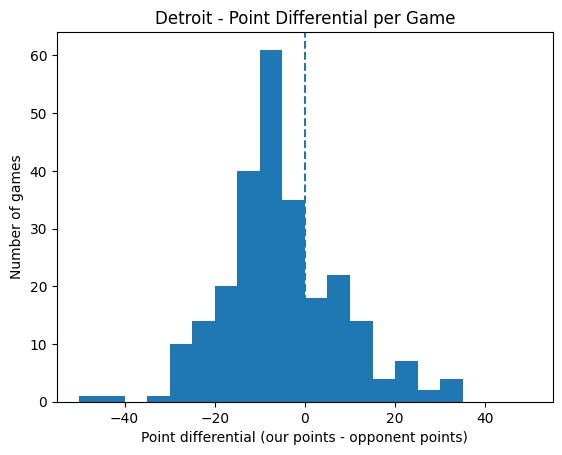

=== 요약 통계 ===
경기 수: 254
평균 득실차: -5.65  |  중앙값: -7.00  |  표준편차: 13.11
대승(≥+20): 13 경기  |  대패(≤-20): 31 경기
클러치 범위(±5점): 57 경기  |  그중 근소 패(-5~-1): 35 경기
홈 평균 득실차: -4.00  |  원정 평균 득실차: -7.28

=== 전략 제안(득실차 분포 기반) ===
1. 근소 패 다수: ATO(타임아웃 후) 플랜, 클러치 FT 라인업, 마지막 2분 턴오버 규칙(첫 패스 안전/핸드오프)
2. 원정 열세: 플레이북 단순화·세컨더리 액션 축소, 초반 얼리오펜스로 리듬 찾기, 원정 첫 타임아웃 빠르게
3. 화력 격차: 코너3/페인트 터치 KPI 지정, 슈터 그린라이트 확대, 수비 매치업 교환 최소화로 실점 런 차단


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 설정
# =========================
TEAM_NAME = "Detroit"      # 예: "Detroit", "Detroit Pistons" 아무거나 포함되면 매칭
BINS = range(-50, 51, 5)   # 히스토그램 구간(점수차 -50~+50, 5점 간격)

# =========================
# 0) 사용 컬럼 확인(이름 다를 수 있어 대비)
# =========================
df = games_season2022.copy()

def pick_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"다음 중 하나가 필요합니다: {candidates}")

HOME_TEAM = pick_col(["HOME_TEAM", "HOME_TEAM_NAME", "HomeTeam", "HOME"])
AWAY_TEAM = pick_col(["VISITOR_TEAM", "VISITOR_TEAM_NAME", "AWAY_TEAM", "AwayTeam", "AWAY"])
PTS_HOME  = pick_col(["PTS_home", "PTS_Home", "PTS_HOME", "HOME_PTS"])
PTS_AWAY  = pick_col(["PTS_away", "PTS_Away", "PTS_AWAY", "AWAY_PTS"])

# =========================
# 1) 디트로이트 경기만 추출(홈/원정 모두)
# =========================
pat = r"\b" + TEAM_NAME.lower() + r"\b"  # 단어 경계 포함(느슨하게 쓰고 싶으면 \b 제거)
is_home_team = df[HOME_TEAM].astype(str).str.lower().str.contains(pat, na=False)
is_away_team = df[AWAY_TEAM].astype(str).str.lower().str.contains(pat, na=False)
g = df.loc[is_home_team | is_away_team, [HOME_TEAM, AWAY_TEAM, PTS_HOME, PTS_AWAY]].copy()

# 점수 숫자화
g[PTS_HOME] = pd.to_numeric(g[PTS_HOME], errors="coerce")
g[PTS_AWAY] = pd.to_numeric(g[PTS_AWAY], errors="coerce")

# =========================
# 2) 득실차 계산(우리점수 - 상대점수)
# =========================
is_home = g[HOME_TEAM].astype(str).str.lower().str.contains(pat, na=False)
our_pts = np.where(is_home, g[PTS_HOME], g[PTS_AWAY])
opp_pts = np.where(is_home, g[PTS_AWAY], g[PTS_HOME])
margin = pd.Series(our_pts - opp_pts, index=g.index, name="margin").dropna()

# =========================
# 3) 히스토그램 그리기
# =========================
plt.figure()
plt.hist(margin, bins=BINS)
plt.axvline(0, linestyle="--")  # 0: 승/패 경계
plt.title(f"{TEAM_NAME} - Point Differential per Game")
plt.xlabel("Point differential (our points - opponent points)")
plt.ylabel("Number of games")
plt.show()

# =========================
# 4) 빠른 요약/해석
# =========================
mean_m = margin.mean()
med_m  = margin.median()
std_m  = margin.std()
blowout_win  = (margin >= 20).sum()
blowout_loss = (margin <= -20).sum()
close_games  = (margin.abs() <= 5).sum()
close_losses = ((margin <= -1) & (margin >= -5)).sum()

print("=== 요약 통계 ===")
print(f"경기 수: {margin.size}")
print(f"평균 득실차: {mean_m:.2f}  |  중앙값: {med_m:.2f}  |  표준편차: {std_m:.2f}")
print(f"대승(≥+20): {blowout_win} 경기  |  대패(≤-20): {blowout_loss} 경기")
print(f"클러치 범위(±5점): {close_games} 경기  |  그중 근소 패(-5~-1): {close_losses} 경기")

# 홈/원정 분리 평균(원본 컬럼 추가 없이 계산)
home_margin = margin[is_home.loc[margin.index]]
away_margin = margin[~is_home.loc[margin.index]]
if not home_margin.empty and not away_margin.empty:
    print(f"홈 평균 득실차: {home_margin.mean():.2f}  |  원정 평균 득실차: {away_margin.mean():.2f}")

# =========================
# 5) 규칙 기반 전략 제안(득실차 분포로 간단 도출)
# =========================
recs = []

# 전반 체감 성능
if mean_m <= -8:
    recs += ["전반적 열세: 페이스 안정화(불필요한 빠른 슛/턴오버 억제) + 수비리바/실점 런 차단 타임아웃 운용"]

# 대패가 많으면: 바닥 안정화
if margin.size and (blowout_loss / margin.size) >= 0.20:
    recs += ["대패 빈도↑: 전원 박스아웃/가드 크랙백 규율, 라이브볼 턴오버 감축, 러닝타임 내 세트오펜스 단순화"]

# 근소 패가 잦으면: 클러치 개선
if close_losses >= max(3, 0.25 * close_games):
    recs += ["근소 패 다수: ATO(타임아웃 후) 플랜, 클러치 FT 라인업, 마지막 2분 턴오버 규칙(첫 패스 안전/핸드오프)"]

# 원정이 특히 나쁘면: 원정 전용 전술
if not home_margin.empty and not away_margin.empty and away_margin.mean() + 3 < home_margin.mean():
    recs += ["원정 열세: 플레이북 단순화·세컨더리 액션 축소, 초반 얼리오펜스로 리듬 찾기, 원정 첫 타임아웃 빠르게"]

# 대승 거의 없고 대패가 많으면: 슈팅/스페이싱·로테이션
if blowout_win < 0.5 * blowout_loss:
    recs += ["화력 격차: 코너3/페인트 터치 KPI 지정, 슈터 그린라이트 확대, 수비 매치업 교환 최소화로 실점 런 차단"]

# 결과 출력
print("\n=== 전략 제안(득실차 분포 기반) ===")
if recs:
    for i, r in enumerate(dict.fromkeys(recs), 1):  # 중복 제거하며 순서 유지
        print(f"{i}. {r}")
else:
    print("특이 패턴이 크지 않습니다. 현재 기조 유지 + 미세조정 권장.")


## 경기 내 슛효율 비교(상대팀과 비교)

In [70]:
import pandas as pd
import numpy as np

# ==== 설정 ====
DET = 'detroit'    # 팀명 키워드(대소문자 무시)
TH_BIG = 0.03      # "크게" 음수로 보는 기준(3%p)
TH_CLOSE = 0.01    # "비슷"한 FG% 격차 기준(±1%p)
MIN_GAMES = 5      # 최소 표본

# 필요한 칼럼만
cols = ['HOME_TEAM','VISITOR_TEAM',
        'FG_PCT_home','FG_PCT_away','FG3_PCT_home','FG3_PCT_away',
        'FT_PCT_home','FT_PCT_away']
g = games_season2022.loc[:, cols].copy()

# 디트로이트 경기만
is_home = g['HOME_TEAM'].astype(str).str.contains(DET, case=False, na=False)
is_away = g['VISITOR_TEAM'].astype(str).str.contains(DET, case=False, na=False)
g = g[is_home | is_away].copy()
if g.empty:
    raise ValueError("디트로이트 경기가 없습니다.")

# 숫자화(+ 퍼센트 문자열 제거)
to_num = lambda s: pd.to_numeric(s.astype(str).str.rstrip('%'), errors='coerce')
for c in cols[2:]:
    g[c] = to_num(g[c])

# 팀/상대 슛 지표 만들기(홈/원정 자동 분기)
idx = g.index
fg_t  = np.where(is_home.loc[idx], g['FG_PCT_home'],  g['FG_PCT_away'])
fg_o  = np.where(is_home.loc[idx], g['FG_PCT_away'],  g['FG_PCT_home'])
fg3_t = np.where(is_home.loc[idx], g['FG3_PCT_home'], g['FG3_PCT_away'])
fg3_o = np.where(is_home.loc[idx], g['FG3_PCT_away'], g['FG3_PCT_home'])
ft_t  = np.where(is_home.loc[idx], g['FT_PCT_home'],  g['FT_PCT_away'])
ft_o  = np.where(is_home.loc[idx], g['FT_PCT_away'],  g['FT_PCT_home'])

# 0~100 스케일이면 0~1로 변환
def scale01(a):
    a = pd.to_numeric(a, errors='coerce')
    return a/100.0 if np.nanmax(a) > 1.001 else a

fg_t, fg_o = scale01(fg_t), scale01(fg_o)
fg3_t, fg3_o = scale01(fg3_t), scale01(fg3_o)
ft_t, ft_o = scale01(ft_t), scale01(ft_o)

# 격차(우리-상대) 계산
fg_gap  = fg_t  - fg_o
fg3_gap = fg3_t - fg3_o
ft_gap  = ft_t  - ft_o

n = len(g)
if n < MIN_GAMES:
    print(f"[알림] 표본이 적습니다: {n} < {MIN_GAMES}")

# 요약 테이블(평균 격차와 음수 비율)
summary = pd.DataFrame({
    '평균격차(our-opp, %p)': [fg_gap.mean()*100, fg3_gap.mean()*100, ft_gap.mean()*100],
    '음수비율(우리<상대)': [(fg_gap<0).mean()*100, (fg3_gap<0).mean()*100, (ft_gap<0).mean()*100]
}, index=['FG%','3P%','FT%']).round(1)
print("=== 슛 성공률 격차 요약 ===")
print(summary)

# 규칙 기반 전략 제안
recs = []

# 1) 3P% 격차 크게 음수 → 외곽 수비/스페이싱
if (fg3_gap.mean() <= -TH_BIG) or ((fg3_gap < -TH_BIG).mean() >= 0.5):
    recs += ["3P% 격차 크게 음수 → 외곽 수비/스페이싱 보완: 풀업3 억제, 드라이브→킥으로 오픈3 창출, 코너 스페이싱 강화"]

# 2) FT% 격차 크게 음수 → 자유투
if (ft_gap.mean() <= -TH_BIG) or ((ft_gap < -TH_BIG).mean() >= 0.5):
    recs += ["FT% 격차 크게 음수 → 자유투 성공률 향상: 루틴 고정·멘탈 코칭, 파울 유도 후 마무리 훈련, 클러치 고 FT% 기용"]

# 3) FG% 비슷 & 3P%만 밀림 → 셀렉션/전술
if (abs(fg_gap.mean()) <= TH_CLOSE) and (fg3_gap.mean() < -TH_BIG):
    recs += ["FG%는 비슷하지만 3P%만 밀림 → 슛 셀렉션/전술 보정: 미드레인지 비중↓, 페인트 터치 뒤 킥아웃, 플레어/해머 액션"]

# FG%가 크게 음수일 때도 처방 내기
if (fg_gap.mean() <= -TH_BIG) or ((fg_gap <= -TH_BIG).mean() >= 0.5):
    recs += ["FG% 격차 크게 음수 → 샷퀄리티/피니시 개선: 미드레인지↓, 페인트 터치↑, 림 시도↑, 드라이브→킥, PnR 롤러 타깃팅, 컷인 활성화"]

print("\n=== 전략 제안 ===")
print("\n".join(f"- {r}" for r in recs) if recs else "뚜렷한 격차 기반 이슈 없음: 현 전략 유지 + 세부 조정")


=== 슛 성공률 격차 요약 ===
     평균격차(our-opp, %p)  음수비율(우리<상대)
FG%               -3.1         67.7
3P%               -1.5         55.5
FT%               -0.7         52.8

=== 전략 제안 ===
- FG% 격차 크게 음수 → 샷퀄리티/피니시 개선: 미드레인지↓, 페인트 터치↑, 림 시도↑, 드라이브→킥, PnR 롤러 타깃팅, 컷인 활성화


In [71]:
import numpy as np
import pandas as pd

TEAM_NAME = "Detroit"  # "Detroit" 또는 "Detroit Pistons"

df = games_season2022.copy()
# 우리 팀이 홈/원정인 경기만 고르기
m_home = df['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False)
m_away = df['VISITOR_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False)
g = df.loc[m_home | m_away, ['HOME_TEAM','VISITOR_TEAM',
                             'PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']].copy()
# 숫자화
for c in ['PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']:
    g[c] = pd.to_numeric(g[c], errors='coerce')

# 우리/상대 값 만들기(홈/원정 자동 처리)
is_home = g['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False)
our_pts = np.where(is_home, g['PTS_home'], g['PTS_away'])
opp_pts = np.where(is_home, g['PTS_away'], g['PTS_home'])
our_ast = np.where(is_home, g['AST_home'], g['AST_away'])
opp_ast = np.where(is_home, g['AST_away'], g['AST_home'])
our_reb = np.where(is_home, g['REB_home'], g['REB_away'])
opp_reb = np.where(is_home, g['REB_away'], g['REB_home'])

# 패한 경기만
valid = ~np.isnan(our_pts) & ~np.isnan(opp_pts) & ~np.isnan(our_ast) & ~np.isnan(opp_ast) & ~np.isnan(our_reb) & ~np.isnan(opp_reb)
lost = valid & (our_pts < opp_pts)

ast_diff = our_ast[lost] - opp_ast[lost]   # (팀AST - 상대AST)
reb_diff = our_reb[lost] - opp_reb[lost]   # (팀REB - 상대REB)

# --- 결과 요약(숫자 몇 개면 끝!) ---
print(f"패한 경기 수: {lost.sum()}")
print(f"어시스트 차이 평균(팀-상대): {pd.Series(ast_diff).mean():.2f}")
print(f"리바운드 차이 평균(팀-상대): {pd.Series(reb_diff).mean():.2f}")
print(f"어시스트가 밀린 패배 비율: {(ast_diff < 0).mean():.0%}")
print(f"리바운드가 밀린 패배 비율: {(reb_diff < 0).mean():.0%}")

# 한 줄 전략(아주 간단)
msg = []
if pd.Series(ast_diff).mean() < -2 or (ast_diff < 0).mean() > 0.6:
    msg.append("AST 개선(0.5초 룰·드라이브→킥)")
if pd.Series(reb_diff).mean() < -2 or (reb_diff < 0).mean() > 0.6:
    msg.append("REB 개선(박스아웃·가드 크랙백)")
print("전략:", ", ".join(msg) if msg else "뚜렷한 약점 없음")


패한 경기 수: 183
어시스트 차이 평균(팀-상대): -3.37
리바운드 차이 평균(팀-상대): -4.50
어시스트가 밀린 패배 비율: 71%
리바운드가 밀린 패배 비율: 69%
전략: AST 개선(0.5초 룰·드라이브→킥), REB 개선(박스아웃·가드 크랙백)


/var/folders/sd/0f929_1n4q512jxct2hwh8nm0000gn/T/ipykernel_16504/2231576843.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([AST_DIFF, REB_DIFF], labels=['AST_DIFF', 'REB_DIFF'])


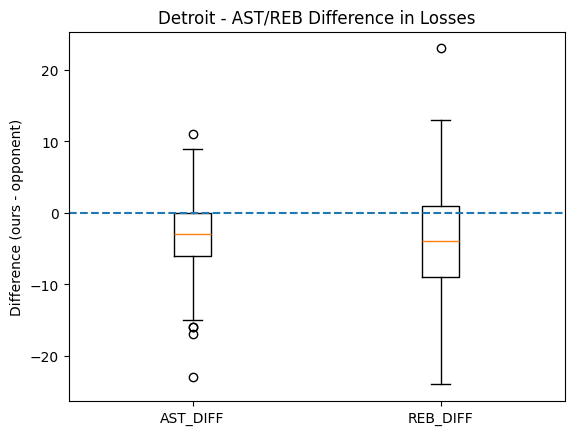


=== 패배 경기: AST/REB 차이 통계 요약 ===
          count   mean  median     var    std  min   q1   q3   iqr  max  \
AST_DIFF    183 -3.366    -3.0  28.211  5.311  -23 -6.0  0.0   6.0   11   
REB_DIFF    183 -4.497    -4.0  62.977  7.936  -24 -9.0  1.0  10.0   23   

          neg_ratio  
AST_DIFF      0.710  
REB_DIFF      0.694  


In [72]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TEAM_NAME = "Detroit"  # 또는 "Detroit Pistons"

df = games_season2022.copy()

# 우리 팀 경기만(홈/원정 모두)
m_home = df['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
m_away = df['VISITOR_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
g = df.loc[m_home | m_away, ['HOME_TEAM','VISITOR_TEAM',
                             'PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']].copy()

# 숫자화
for c in ['PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']:
    g[c] = pd.to_numeric(g[c], errors='coerce')

# 팀 관점 값(홈/원정 자동 처리)
is_home = g['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
our_pts = np.where(is_home, g['PTS_home'], g['PTS_away'])
opp_pts = np.where(is_home, g['PTS_away'], g['PTS_home'])
our_ast = np.where(is_home, g['AST_home'], g['AST_away'])
opp_ast = np.where(is_home, g['AST_away'], g['AST_home'])
our_reb = np.where(is_home, g['REB_home'], g['REB_away'])
opp_reb = np.where(is_home, g['REB_away'], g['REB_home'])

# 패한 경기만
lost = (our_pts < opp_pts)
AST_DIFF = pd.Series(our_ast[lost] - opp_ast[lost], name='AST_DIFF').dropna()
REB_DIFF = pd.Series(our_reb[lost] - opp_reb[lost], name='REB_DIFF').dropna()


# 상자그림(음수 쪽이면 열세)
plt.figure()
plt.boxplot([AST_DIFF, REB_DIFF], labels=['AST_DIFF', 'REB_DIFF'])
plt.axhline(0, linestyle='--')
plt.title(f'{TEAM_NAME} - AST/REB Difference in Losses')
plt.ylabel('Difference (ours - opponent)')
plt.show()

stats = pd.DataFrame({
    "count":   [AST_DIFF.size,            REB_DIFF.size],
    "mean":    [AST_DIFF.mean(),          REB_DIFF.mean()],          # 평균(중심값)
    "median":  [AST_DIFF.median(),        REB_DIFF.median()],        # 중앙값(박스 가운데 선)
    "var":     [AST_DIFF.var(ddof=1),     REB_DIFF.var(ddof=1)],     # 분산(표본분산)
    "std":     [AST_DIFF.std(ddof=1),     REB_DIFF.std(ddof=1)],     # 표준편차
    "min":     [AST_DIFF.min(),           REB_DIFF.min()],
    "q1":      [AST_DIFF.quantile(0.25),  REB_DIFF.quantile(0.25)],  # 1사분위(Q1)
    "q3":      [AST_DIFF.quantile(0.75),  REB_DIFF.quantile(0.75)],  # 3사분위(Q3)
    "iqr":     [AST_DIFF.quantile(0.75)-AST_DIFF.quantile(0.25),
                REB_DIFF.quantile(0.75)-REB_DIFF.quantile(0.25)],    # IQR=Q3-Q1
    "max":     [AST_DIFF.max(),           REB_DIFF.max()],
    "neg_ratio":[(AST_DIFF < 0).mean(),   (REB_DIFF < 0).mean()]     # 음수(열세) 비율
}, index=["AST_DIFF","REB_DIFF"])

print("\n=== 패배 경기: AST/REB 차이 통계 요약 ===")
print(stats.round(3))


In [76]:
games_details_regular = pd.read_csv('games_details_regular.csv')



/var/folders/sd/0f929_1n4q512jxct2hwh8nm0000gn/T/ipykernel_16504/124461255.py:79: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([AST_DIFF, REB_DIFF, TOV_DIFF], labels=['AST_DIFF','REB_DIFF','TOV_DIFF'])


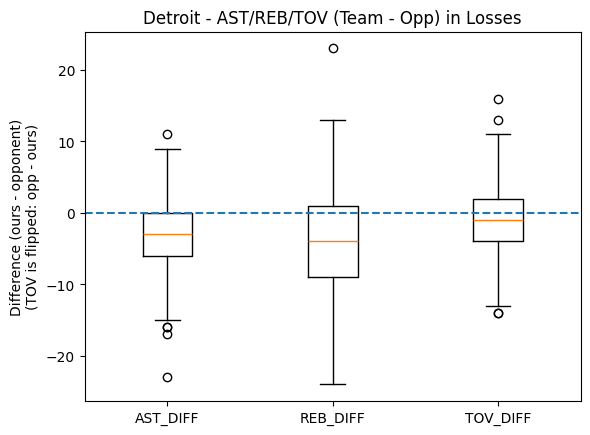

패배 경기 수(유효): 183
평균 차이: {'AST_DIFF': -3.37, 'REB_DIFF': -4.5, 'TOV_DIFF(opp-ours)': -0.89}


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) 설정
# =========================
TEAM_NAME = "Detroit"  # 약칭만 있다면 "DET"로 바꾸세요

# =========================
# 1) 우리 팀 경기 추출 (games_season2022에서)
# =========================
df = games_season2022.copy()

m_home = df['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
m_away = df['VISITOR_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)

# GAME_ID 포함해서 가져옵니다!
g = df.loc[m_home | m_away, ['GAME_ID','HOME_TEAM','VISITOR_TEAM',
                             'PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']].copy()

# 숫자화
for c in ['PTS_home','PTS_away','AST_home','AST_away','REB_home','REB_away']:
    g[c] = pd.to_numeric(g[c], errors='coerce')

# 우리/상대 점수·어시스트·리바운드 (홈/원정 자동 처리)
is_home = g['HOME_TEAM'].astype(str).str.contains(TEAM_NAME, case=False, na=False, regex=False)
our_pts = np.where(is_home, g['PTS_home'], g['PTS_away'])
opp_pts = np.where(is_home, g['PTS_away'], g['PTS_home'])
our_ast = np.where(is_home, g['AST_home'], g['AST_away'])
opp_ast = np.where(is_home, g['AST_away'], g['AST_home'])
our_reb = np.where(is_home, g['REB_home'], g['REB_away'])
opp_reb = np.where(is_home, g['REB_away'], g['REB_home'])

# =========================
# 2) games_details_regular.csv에서 경기별/팀별 턴오버 합계 만들기
# =========================
gd = pd.read_csv('games_details_regular.csv')

# 컬럼 이름 추정 (팀 라벨과 턴오버 컬럼을 찾습니다)
team_col_candidates = ['TEAM_NAME','TEAM','TEAM_CITY','TEAM_ABBREVIATION']
to_col_candidates   = ['TO','TOV','TURNOVERS']

TEAM_COL = next((c for c in team_col_candidates if c in gd.columns), None)
TO_COL   = next((c for c in to_col_candidates   if c in gd.columns), None)
if TEAM_COL is None or TO_COL is None:
    raise KeyError("games_details_regular.csv에 TEAM(=TEAM_NAME/TEAM_CITY/TEAM_ABBREVIATION) 또는 TO/TOV 컬럼이 필요합니다.")

gd[TEAM_COL] = gd[TEAM_COL].astype(str)
gd[TO_COL]   = pd.to_numeric(gd[TO_COL], errors='coerce')

# (A) 우리 팀 턴오버: 팀명이 TEAM_NAME을 포함한 행만 모아서 GAME_ID별 합계
our_tov_by_game = (gd[gd[TEAM_COL].str.contains(TEAM_NAME, case=False, na=False)]
                   .groupby('GAME_ID')[TO_COL].sum()
                  ).rename('OUR_TOV')

# (B) 경기 전체 턴오버 합계 → 상대 턴오버 = 전체 - 우리
total_tov_by_game = gd.groupby('GAME_ID')[TO_COL].sum().rename('TOTAL_TOV')
opp_tov_by_game   = (total_tov_by_game - our_tov_by_game).rename('OPP_TOV')

# (C) GAME_ID로 조인
g = (g.merge(our_tov_by_game, on='GAME_ID', how='left')
       .merge(opp_tov_by_game, on='GAME_ID', how='left'))

# =========================
# 3) 패배 경기만 선택 + 차이값 계산
# =========================
lost = (our_pts < opp_pts) & g['OUR_TOV'].notna() & g['OPP_TOV'].notna()

AST_DIFF = pd.Series(our_ast[lost] - opp_ast[lost], name='AST_DIFF').dropna()
REB_DIFF = pd.Series(our_reb[lost] - opp_reb[lost], name='REB_DIFF').dropna()
# 턴오버는 적을수록 좋으므로, 해석 통일을 위해 "상대 - 우리"로 뒤집습니다(음수=우리 약점).
TOV_DIFF = pd.Series(g.loc[lost, 'OPP_TOV'] - g.loc[lost, 'OUR_TOV'], name='TOV_DIFF').dropna()

# =========================
# 4) 상자그림: AST / REB / TOV 나란히
# =========================
plt.figure()
plt.boxplot([AST_DIFF, REB_DIFF, TOV_DIFF], labels=['AST_DIFF','REB_DIFF','TOV_DIFF'])
plt.axhline(0, linestyle='--')
plt.title(f'{TEAM_NAME} - AST/REB/TOV (Team - Opp) in Losses')
plt.ylabel('Difference (ours - opponent)\n(TOV is flipped: opp - ours)')
plt.show()

# (선택) 간단 숫자 요약
print("패배 경기 수(유효):", int(lost.sum()))
print("평균 차이:", pd.Series({
    'AST_DIFF': AST_DIFF.mean(),
    'REB_DIFF': REB_DIFF.mean(),
    'TOV_DIFF(opp-ours)': TOV_DIFF.mean()
}).round(2).to_dict())